In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 
import nltk.stem.porter
porter_stemmer=nltk.stem.porter.PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from helpers import * 
import nltk
from sklearn.metrics.pairwise import linear_kernel





ModuleNotFoundError: No module named 'helpers'

In [ ]:
#reading the dataset
emails = pd.read_csv('split_emails.csv')

## preprocessing and splitting (code= 1st two function of helper.py)

In [4]:
#creating a dataframe
email_df = pd.DataFrame(parse_into_emails(emails.message))


In [5]:
# Drop emails with empty body, to or from_ columns.
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)

In [7]:
#finding top words
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"

In [8]:
email_df.head()

,body,from_,to
0,Here is our forecast,phillip.allen@enron.com,tim.belden@enron.com
1,Traveling to have a business meeting takes the...,phillip.allen@enron.com,john.lavorato@enron.com
2,test successful. way to go!!!,phillip.allen@enron.com,leah.arsdall@enron.com
3,"Randy,Can you send me a schedule of the salary...",phillip.allen@enron.com,randall.gay@enron.com
5,"Greg,How about either next Tuesday or Thursday...",phillip.allen@enron.com,greg.piper@enron.com


In [10]:
#stemming
body = email_df.body
def stemmingDF(body):
    bigl=[]
    for string in body:
        lis=string.split()
        l=[]
        for word in lis:
            if word.isalpha()==True:                
                if word not in stopwords:
                    if len(word)!=1:
                        word=word.lower()
                        word=lemmatizer.lemmatize(word)
                        l.append(word)
        str1=' '.join(l)
        bigl.append(str1)
    return bigl

email_df["body_new"] = stemmingDF(body)



In [12]:
email_df.body_new[1]

'traveling business meeting take fun especially prepare suggest holding business plan meeting trip formal business try honest opinion trip desired far business think productive try stimulate discussion different group working too presenter speaks quiet just waiting the meeting better held round table discussion suggestion play golf rent ski boat jet flying take'

In [14]:
#print top features
X = vect.fit_transform(email_df.body_new)
features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

     features     score
0    business  0.335930
1        trip  0.272305
2     meeting  0.252588
3  discussion  0.213792
4         try  0.192273
5   presenter  0.186883
6   stimulate  0.183843
7      speaks  0.181162
8      honest  0.181162
9       quiet  0.174613


In [ ]:
#kmeans clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X.todense())
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 6), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [15]:
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(X)

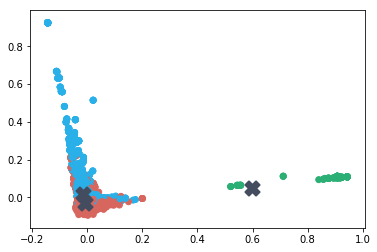

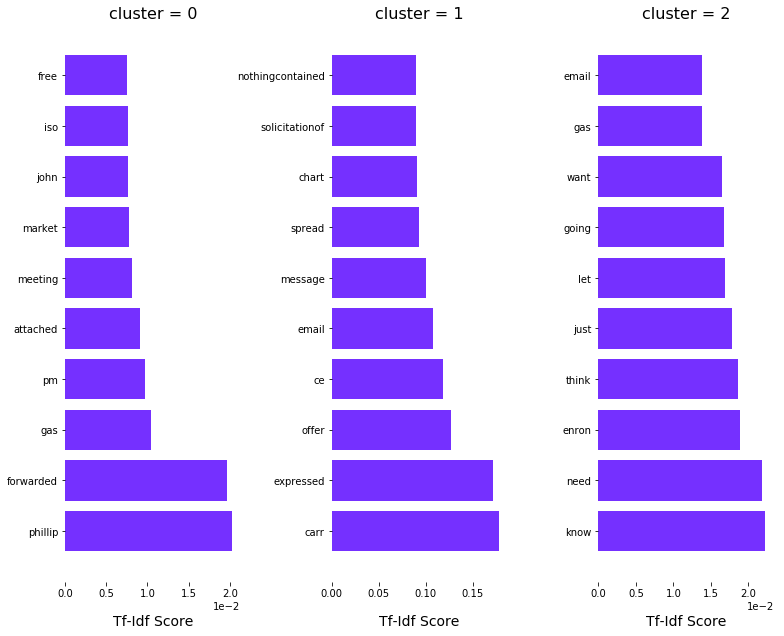

In [16]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

plt.scatter(coords[:, 0], coords[:, 1], c=colors)
# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()

#Use this to print the top terms per cluster with matplotlib.
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 10))

In [18]:
#cosine similarity
vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
vec_train = vec.fit_transform(email_df.body)

query = "market"

vec_query = vec.transform([query])

cosine_sim = linear_kernel(vec_query, vec_train).flatten()

In [20]:
def cos_score(lst):   
    leve_m=np.zeros([10,10])
    for i,word1 in enumerate(lst['features']):
        for j,word2 in enumerate(lst['features']):
            if word1!=word2:
                leve_m[i][j]=linear_kernel(lst['score'][i],lst['score'][j]).flatten()
    return leve_m.mean()

In [21]:
lst0=top_feats_per_cluster(X,labels,features,0.1,10)[0]
lst1=top_feats_per_cluster(X,labels,features,0.1,10)[1]
lst2=top_feats_per_cluster(X,labels,features,0.1,10)[2]

In [22]:
score0=cos_score(lst0)
score1=cos_score(lst1)
score2=cos_score(lst2)

In [23]:
print(score0)
print(score1)
print(score2)

0.00010230824861825109
0.012157754265246663
0.00028203377657255344


In [ ]:
#import scipy.cluster.hierarchy as sch
from scipy.cluster import hierarchy

Z = hierarchy.linkage(X, 'ward')
dn = hierarchy.dendrogram(Z)

#dendrogram=sch.dendrogram(sch,linkage(X,method='ward'))
plt.title('Dendrogram')
#plt.xlabel('Customers')
plt.ylabel('Euclidean distances')

plt.xlim(0,800)
plt.show()